In [1]:
import sys
from pathlib import Path
from PIL import Image
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from molmo_utils import load_model, do_inference, get_coordinates, refactor_coordinates_to_where_to_place
from utils import extract_all_trajectories, visualize_points_on_image, plot_euclidean_bplot

KeyboardInterrupt: 

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
tasks, trajectories, ground_truths, _ = extract_all_trajectories("../data/trajectory_kit")

In [4]:
prompt_start = "You are the robot in the picture. Your task is to: "
prompt_1 = " To complete this task, do two things. 1. Find the relevant object and point to it. 2. If your task somehow includes moving or putting the object somewhere in the image point to that location."
prompt_end = " Your output format should be like this: (x1, y1), (x2, y2), with (x1, y1) beeing the coordinates of the object to move and (x2, y2) the place to move it to. Dont output anything else."

In [8]:
for i in trajectories:
    for j in i:
        with Image.open(j) as image:
            print(image)
        print(j)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x1507F02BA0D0>
../data/trajectory_kit/task2/0.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x1507F6E045B0>
../data/trajectory_kit/task2/1.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x15092B505130>
../data/trajectory_kit/task2/2.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x150929B9BF70>
../data/trajectory_kit/task2/3.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x1507F543A970>
../data/trajectory_kit/task2/4.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x15092B505130>
../data/trajectory_kit/task2/5.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x150929B9BF70>
../data/trajectory_kit/task2/6.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x1507F6E045B0>
../data/trajectory_kit/task2/7.jpeg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2

Task: close the microwave.
Run: 2 - Output:  (84.7, 17.8), (84.7, 26.3)
Run: 4 - Output:  (85.2, 20.0), (85.2, 11.9)
Run: 6 - Output:  (85.2, 22.1), (85.2, 12.6)
Run: 8 - Output:  (85.6, 20.2), (86.0, 12.1)
Run: 10 - Output:  (87.5, 18.3), (87.5, 24.0)


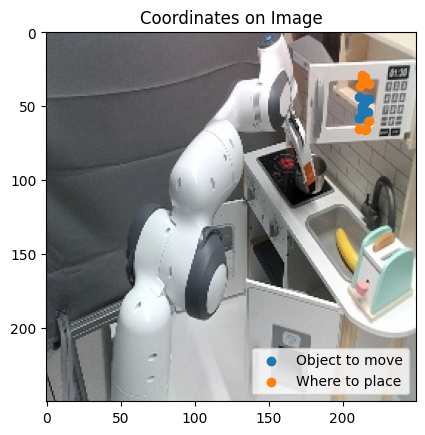

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [11]:
for i in range(len(tasks)):
    outputs = []
    trajectory = trajectories[i]
    task = tasks[i]
    prompt = prompt_start + task + prompt_1 + prompt_end

    print(f"Task: {task}")
    for image_path in trajectory:
        with Image.open(image_path) as image:
            image_width = image.width
            image_height = image.height
        runs_with_two_coords = 0
        for j in range(10):
            output = do_inference(image_path, prompt, model, processor)
            coordinates = get_coordinates(output, image_width, image_height)
            if len(coordinates) == 2:
                runs_with_two_coords += 1
                outputs.append(coordinates)
    
            if ((j+1) % 2) == 0: 
                print(f"Run: {j + 1} - Output: {output}")
    
        labels = ["Object to move", "Where to place"]
    
        outputs = refactor_coordinates_to_where_to_place(outputs)
        visualize_points_on_image(image_path, labels, outputs)
        plot_euclidean_bplot(labels, outputs, ground_truths, "Test")
        print(f"Runs with exactly two coordinates: {runs_with_two_coords}")
        print("")
        print("")

In [15]:
import os
from PIL import Image

def close_all_images(root_dir):
    closed_images = 0
    # Walk through all subdirectories and files in the given root directory
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            # Check if the file is an image based on its extension
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                image_path = os.path.join(subdir, file)
                try:
                    image = Image.open(image_path)
                    image.close()
                    closed_images += 1
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
    print(f"Found and closed {closed_images} images.")

# Example usage
root_directory = "../data"
close_all_images(root_directory)


Found and closed 121 images.
